[Todo]

* Define commonly used operations into functions/classes to reuse

# Player Statistics

This notebook builds an ML model for predicting the position of a player given their statistics.

##### Data Sources:

##### The attributes I chose to use in building the model include:

**Points, Assists, Rebounds, Steals and Blocks**, all on a per game basis. The model would have been improved by using statistics that further distinguish positions such as three point percentage (as guards and forwards are usually much better than centers in this department), turnovers or free throw percentage.  

However, due to these more advanced statistics rarely being recorded outside of professional games, I decided to only use the traditionally recorded statistics of points, assists, rebounds, steals and blocks as the average user who may have only played up to high school basketball would either have these attributes recorded or know a rough estimate of their numbers for these attributes. For example, american highschool varsity basketball only records these statistics: [See Here](https://www.maxpreps.com/basketball/stat-leaders/).

Potential Resources to download stats:

* https://www.basketball-reference.com/leagues/NBA_2023_per_game.html (Download as many seasons as possible). For each download, need to read the file in, and collate player statistics such that players who played on multiple teams that season have their stats collated.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy.stats import uniform, loguniform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

sns.set_theme()
%matplotlib inline

In [2]:
np.random.seed(0)

# Data Preprocessing

In [3]:
# Reading in data
player_statistics = pd.read_csv(os.path.join("data", "Seasons_Stats.csv"))
active_players = pd.read_csv(os.path.join("data", "active_players.csv"))
active_players_processed = pd.read_csv(os.path.join("data", "active_players_processed.csv"))
player_statistics_processed = pd.read_csv(os.path.join("data", "player_stats_processed.csv"))

In [4]:
player_statistics.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [5]:
active_players.head()

,playerid,fname,lname,position,height,weight,birthday,country,school,draft_year,draft_round,draft_number
0,1630173,Precious,Achiuwa,Forward,6-8,225,1999-09-19,Nigeria,Memphis,2020,1.0,20.0
1,203500,Steven,Adams,Center,6-11,265,1993-07-20,New Zealand,Pittsburgh,2013,1.0,12.0
2,1628389,Bam,Adebayo,Center-Forward,6-9,255,1997-07-18,USA,Kentucky,2017,1.0,14.0
3,1630534,Ochai,Agbaji,Guard,6-5,215,2000-04-20,USA,Kansas,2022,1.0,14.0
4,1630583,Santi,Aldama,Forward-Center,7-0,215,2001-01-10,Spain,Loyola-Maryland,2021,1.0,30.0


### Handling the player statistics dataset

First, I'm going to convert all column headers into lowercase to have a consistent case between all columns.

In [6]:
player_statistics.columns = player_statistics.columns.str.lower()

Now, I'm going to keep only relevant attributes that are feasible (see explanation above) and may have a relationship with a players position (Year, Age).

In [7]:
player_statistics = player_statistics[['player', 'pos', 'pts', 'ast', 'trb', 'stl', 'blk', 'age', 'year', 'g']]
player_statistics.head()

,player,pos,pts,ast,trb,stl,blk,age,year,g
0,Curly Armstrong,G-F,458.0,176.0,NaN,NaN,NaN,31.0,1950.0,63.0
1,Cliff Barker,SG,279.0,109.0,NaN,NaN,NaN,29.0,1950.0,49.0
2,Leo Barnhorst,SF,438.0,140.0,NaN,NaN,NaN,25.0,1950.0,67.0
3,Ed Bartels,F,63.0,20.0,NaN,NaN,NaN,24.0,1950.0,15.0
4,Ed Bartels,F,59.0,20.0,NaN,NaN,NaN,24.0,1950.0,13.0


Next, we're going to drop all NA values as we're going to want to keep only players with all the relevant statistics. Furthermore, any duplicates entries will be dropped.

In [8]:
# Checking the shape, number of duplicates and missing values
print(f'The number of rows in the dataset is: {player_statistics.shape[0]}')
print(f'The number of columns/features in the dataset is: {player_statistics.shape[1]}')
print(f'The number of duplicate entries in the dataset is: {player_statistics.duplicated().sum()}')
print(f'The number of missing values in the dataset is: {player_statistics.isna().sum().sum()}')

The number of rows in the dataset is: 24691
The number of columns/features in the dataset is: 10
The number of duplicate entries in the dataset is: 67
The number of missing values in the dataset is: 8644


In [9]:
player_statistics = player_statistics.dropna()
player_statistics = player_statistics.drop_duplicates().reset_index(drop=True)

In [10]:
# Checking the number of duplicates and missing values
print(f'The number of duplicate entries in the dataset is: {player_statistics.duplicated().sum()}')
print(f'The number of missing values in the dataset is: {player_statistics.isna().sum().sum()}')

The number of duplicate entries in the dataset is: 0
The number of missing values in the dataset is: 0


It is evident that the statistics are shown as **totals**, and not their statistics **per game**. Although users could calculate their total statistics, it's more common that a players statistics are recorded as per game. Therefore, next we will convert all the statistics into per game.

In [11]:
# Convert stats into per game
stats_cols = ['pts', 'ast', 'trb', 'stl', 'blk']
for col in stats_cols:
    player_statistics[col] = np.round(player_statistics[col].div(player_statistics['g']), 2)
    
# Drop games
player_statistics.drop(columns=['g'], inplace=True)

In [12]:
player_statistics.head()

,player,pos,pts,ast,trb,stl,blk,age,year
0,Zaid Abdul-Aziz,C,10.95,2.10,11.68,1.01,1.32,27.0,1974.0
1,Kareem Abdul-Jabbar*,C,27.05,4.77,14.54,1.38,3.49,26.0,1974.0
2,Don Adams,SF,10.26,1.91,6.05,1.49,0.16,26.0,1974.0
3,Rick Adelman,PG,3.31,1.02,1.25,0.65,0.02,27.0,1974.0
4,Lucius Allen,PG,17.61,5.19,4.04,1.90,0.31,26.0,1974.0


It is evident that the Guard position is broken down into PG (Point Guard) and SG (Shooting Guard). Additionally, the Forward position is broken down into SF (Small Forward) and Power Forward (PF). 

Similar to before, we're trying to predict the general position of a player (Guard, Forward, Center) and so we handle this below.

In [13]:
player_statistics['pos'] = player_statistics['pos'].apply(lambda x: x[-1])
player_statistics.head()

,player,pos,pts,ast,trb,stl,blk,age,year
0,Zaid Abdul-Aziz,C,10.95,2.10,11.68,1.01,1.32,27.0,1974.0
1,Kareem Abdul-Jabbar*,C,27.05,4.77,14.54,1.38,3.49,26.0,1974.0
2,Don Adams,F,10.26,1.91,6.05,1.49,0.16,26.0,1974.0
3,Rick Adelman,G,3.31,1.02,1.25,0.65,0.02,27.0,1974.0
4,Lucius Allen,G,17.61,5.19,4.04,1.90,0.31,26.0,1974.0


In [14]:
player_statistics['pos'].value_counts()

pos
F    8394
G    8260
C    4142
Name: count, dtype: int64

In [15]:
# Export player statistics processed
#player_statistics.to_csv(os.path.join("data", "player_stats_processed.csv"))

* Now we only have the desired G, F and C positions.

# Problem definition

In [16]:
player_statistics['pos'].value_counts()

pos
F    8394
G    8260
C    4142
Name: count, dtype: int64

Since 40% of observations are Forward and Guards, but just 20% of observations are Centers, this represents an **imbalanced, multi-classs classification problem.** Additionally, False Positive's and False Negative's are equally importance (i.e. we want fair performance predicting across all classes).

As such, we will use appropriate metrics like:

* `balanced_accuracy`,
* `f1_macro`

# Building ML Model

### Preparation of dataset

In [17]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import HistGradientBoostingClassifier

In [18]:
# separate data
target_name = "pos"
target = player_statistics[target_name]
data = player_statistics.drop(columns=[target_name, "player"])

# retrieve column types
numerical_columns_selector = selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(data)

# define transformers
numerical_preprocessor = StandardScaler()

# define column transformer
preprocessor = ColumnTransformer(
    [
        ("numerical_preprocessing", numerical_preprocessor, numerical_columns)
    ],
    remainder="passthrough"
)

### Defining PlayerStatisticsModel class

In [ ]:
class PlayerStatisticsModel:
    """
     This class enables easy the creation and evaluation of different models to predict a players position based
     on their statistics.
    """
    def __init__(self, model, preprocessor: ColumnTransformer, data: pd.DataFrame, target: pd.Series, cv: int):
        """
         Initialisation of PlayerStatisticsModel class.
        
         Inputs:
          - model: sklearn machine learning model class
          - preprocessor (ColumnTransformer): preprocessing steps
          - data: input features
          - target: input target
          - cv: number of cv folds to estimate generalisability of model
        """
        self.metrics = ["balanced_accuracy", "f1_macro"]  # metrics to evaluate/fit models
        self.cv = cv  # number of cv folds
        self.results = pd.DataFrame()   # dataframe to store performance results of models
        self.data = data
        self.target = target
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data, target, test_size = 0.25, stratify=target, random_state=42)
        self.preprocessor = preprocessor
        self.model = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("model", model)
            ]
        )
    def print_cv_results(self, dict_results:dict[tuple]):
        """
         Prints the mean and standard deviation cross-validation score for a specified metrics in a pretty format.
        
         Inputs:
          - dict_results (dict[tuple]): the mean & std results of a model on all evaluation metrics
        """
        for metric, value in dict_results.items():
            print(f"The mean cross-validation {metric} score is: "
            f"{value[0]:.3f} ± {value[1]:.3f}")
    def plot_fold_comparison(self, metric: str, fold_results: tuple[list[int]], label_names: tuple[str], colors: tuple[str]):
        """
         Plots a comparison of the model's evaluation metric (i.e. performance) on each individual cross-validation
         fold. If there are 4 cross-validation folds, a scatterplot with four dots will be plotted.
        
         Inputs:
          - metric (str): sklearn evaluation metric of choice
          - fold_results (tuple[list[int]]): tuple containing the fold results of each model
          - label_names (tuple[str]): names to give each to each model in the legend of plot
          - colors (tuple[str]): colors to give each model in the plot
        """
        # handle edge case: user passes in invalid metric to plot
        if metric not in self.metrics:
            raise Exception(f"Please pass in a valid metric: {self.metrics}")
        else:
            fig, ax = plt.subplots(figsize=(6, 5))
            # iterate through each model's fold_result, adding scatterplots
            for i in range(len(fold_results)):
                indicies = np.arange(len(fold_results[i][metric]))
                sns.scatterplot(x=indicies, y=fold_results[i][metric], color=f"tab:{colors[i]}", label=label_names[i], ax=ax)
            # plot axis settings
            ax.set_xlabel("Cross-validation iteration")
            ax.set_ylabel("Balanced Accuracy")
            ax.set_title(f"{self.cv}-Fold {metric}")
            ax.set_xticks(np.arange(0, self.cv))
            ax.set_ylim(0,1)
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    def _add_model_results(self, model_result: dict[list], model_name: str):
        """
         Anonymous function that concatenates the mean and standard deviation cross-validation score for all
         specified metrics of a model onto a pre-existing dataframe (self.results). This enables us to 
         quickly compare the cv-performance of models as we build them.

         Inputs:
          - model_result (dict[list]): dictionary containing the mean & std results for each model metric
          - model_name (str): name of the model that will exist as its index in the self.results df
        """   
        # Gets model results as df to append to self.results
        df = pd.DataFrame(model_result)
        # extract rows and add suffixes to column names, then combine
        mean_row = df.iloc[0].rename(lambda col: f"{col}_mean")
        std_row = df.iloc[1].rename(lambda col: f"{col}_std")
        flattened_series = pd.concat([mean_row, std_row])
        flattened_df = pd.DataFrame([flattened_series])
        # set the index to the model name
        flattened_df.index = [model_name]
        # if model already exists in results df, then replace. Otherwise, append.
        if model_name in list(self.results.index):
            self.results.loc[model_name] = flattened_df.iloc[0]
        else:
            self.results = pd.concat([self.results, flattened_df])
    def cv_score(self, model_name: str) -> tuple[dict[list], dict[list]]:
        """
         Runs cross-validation on the default model (i.e. without hyperparameter tuning), obtaining the 
         performance of the model.

         Inputs:
          - model_name (str): name of the model that will exist as its index in the self.results df
         
         Returns:
          - dict_scores_agg (dict[list]): dictionary containing the mean & std results for each model metric
          - dict_scores_folds (dict[list]): dictionary containing the model metric results for each fold
        """   
        # get CV scores for default model
        dict_scores_agg = dict()
        dict_scores_folds = dict()
        for metric in self.metrics:
            cv_results = cross_validate(self.model, data, target, cv=self.cv, scoring=metric)
            scoring = cv_results['test_score']
            dict_scores_agg[metric] = (scoring.mean(), scoring.std())
            dict_scores_folds[metric] = scoring
        self._add_model_results(dict_scores_agg, model_name)
        return dict_scores_agg, dict_scores_folds
    def grid_search_cv_score(self, model_name: str, param_grid: dict):
        """
         Fits a model with grid_search to tune its hyperparameters. Then performs nested cross-validation to
         obtain an estimate of the generalisability of the model & variance of this estimate.

         Inputs:
          - model_name (str): name of the model that will exist as its index in the self.results df
          - param_grid (dict): grid of hyperparameters to iterate through
         
         Returns:
          - dict_scores_agg (dict[list]): dictionary containing the mean & std results for each model metric
          - dict_scores_folds (dict[list]): dictionary containing the model metric results for each fold
          - best_model: sklearn model of best performing model after gridsearch hyperparameter tuning
        """   
        model_grid_search = GridSearchCV(self.model, param_grid=param_grid, n_jobs=-1, scoring=self.metrics, refit=self.metrics[0], verbose=1)
        # fit grid search on training data to extract best model
        model_grid_search.fit(self.X_train, self.y_train)
        best_model = model_grid_search.best_estimator_
        # get nested CV scores for best model
        dict_scores_agg = dict()
        dict_scores_folds = dict()
        # perform nested cv for each metric, storing results in dictionaries
        for metric in self.metrics:
            cv_results = cross_validate(model_grid_search, data, target, cv=self.cv, n_jobs=-1, scoring=metric)
            scoring = cv_results['test_score']
            dict_scores_agg[metric] = (scoring.mean(), scoring.std())
            dict_scores_folds[metric] = scoring
        # add results to dataframe for easy model comparison
        self._add_model_results(dict_scores_agg, model_name)
        return dict_scores_agg, dict_scores_folds, best_model
    def randomised_search_cv_score(self, model_name: str, param_distributions: dict, n_iter: int):
        """
         Fits a model with randomised_search to tune its hyperparameters. Then performs nested cross-validation to
         obtain an estimate of the generalisability of the model & variance of this estimate.

         Inputs:
          - model_name (str): name of the model that will exist as its index in the self.results df
          - param_distributions (dict): range of possible values each hyperparameter that can be sampled
          - n_iter (int): number of iterations to run randomised_search (i.e. models to be fitted & evaluated)
         
         Returns:
          - dict_scores_agg (dict[list]): dictionary containing the mean & std results for each model metric
          - dict_scores_folds (dict[list]): dictionary containing the model metric results for each fold
          - best_model: sklearn model of best performing model after gridsearch hyperparameter tuning
        """   
        model_random_search = RandomizedSearchCV(self.model, param_distributions=param_distributions, n_iter=n_iter, n_jobs=-1, scoring=self.metrics, refit=self.metrics[0], verbose=1)
        # fit grid search on training data to extract best model
        model_random_search.fit(self.X_train, self.y_train)
        best_model = model_random_search.best_estimator_
        # get nested CV scores for best model
        dict_scores_agg = dict()
        dict_scores_folds = dict()
        # perform nested cv for each metric, storing results in dictionaries
        for metric in self.metrics:
            cv_results = cross_validate(model_random_search, data, target, cv=self.cv, n_jobs=-1, scoring=metric)
            scoring = cv_results['test_score']
            dict_scores_agg[metric] = (scoring.mean(), scoring.std())
            dict_scores_folds[metric] = scoring
        # add results to dataframe for easy model comparison    
        self._add_model_results(dict_scores_agg, model_name)
        return dict_scores_agg, dict_scores_folds, best_model

### Linear model - Logistic Regression

#### Estimating generalisability of untuned Logistic Regression model

In [20]:
psm = PlayerStatisticsModel(LogisticRegression(random_state=42), preprocessor, data, target, cv=4)
log_cv_score_agg, log_cv_score = psm.cv_score(model_name='base_log_reg')
psm.print_cv_results(log_cv_score_agg)

The mean cross-validation balanced_accuracy score is: 0.707 ± 0.003
The mean cross-validation f1_macro score is: 0.717 ± 0.004


#### Estimating generalisability of tuned Logistic Regression model with GridSearchCV

In [21]:
param_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['saga'],
    'model__l1_ratio': [0, 0.5, 1],
    'model__class_weight': [None, 'balanced']
}
log_gridsearch_cv_score_agg, log_gridsearch_cv_score, log_gridsearch_model = psm.grid_search_cv_score(param_grid=param_grid, model_name='gridsearch_log_reg')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarni

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarni

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarni

In [22]:
psm.print_cv_results(log_gridsearch_cv_score_agg)

The mean cross-validation balanced_accuracy score is: 0.748 ± 0.008
The mean cross-validation f1_macro score is: 0.731 ± 0.015


* We observe a significant improvement in balanced_accuracy with GridSearchCV, and a slight improvement in f1_macro. Overall, the model performs better.  

* However, there may exist unimportant parameters we tuned. We can turn to RandomisedSearchCV aswell.

#### Estimating generalisability of tuned Logistic Regression model with RandomizedSearchCV

In [23]:
param_dist = {
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__C': loguniform(1e-3, 1e3),    # continuous sampling over [0.001, 1000]
    'model__solver': ['saga'],
    'model__l1_ratio': uniform(0, 1),    # continuous over [0,1]
    'model__class_weight': [None, 'balanced']
}

log_randomsearch_cv_score_agg, log_randomsearch_cv_score, log_randomsearch_model = psm.randomised_search_cv_score(param_distributions=param_dist, n_iter=50, model_name='randomsearch_log_reg')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_mode

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarni

In [24]:
psm.print_cv_results(log_randomsearch_cv_score_agg)

The mean cross-validation balanced_accuracy score is: 0.748 ± 0.008
The mean cross-validation f1_macro score is: 0.732 ± 0.016


In [25]:
psm.results

,balanced_accuracy_mean,f1_macro_mean,balanced_accuracy_std,f1_macro_std
base_log_reg,0.706726,0.717082,0.002877,0.003759
gridsearch_log_reg,0.748086,0.730542,0.007743,0.014869
randomsearch_log_reg,0.748267,0.731552,0.007712,0.016201


**Which is the better linear model (tuned w/ GridSearchCV or RandomisedSearchCV)?**

* We observe almost identical performance and variance in balanced_accuracy and f1_macro between the two models. However, the computational performance significantly improves with RandomisedSearchCV - which is important when we extend our dataset size.

* Another way of comparing performance is by counting the number of folds each model performs better in.

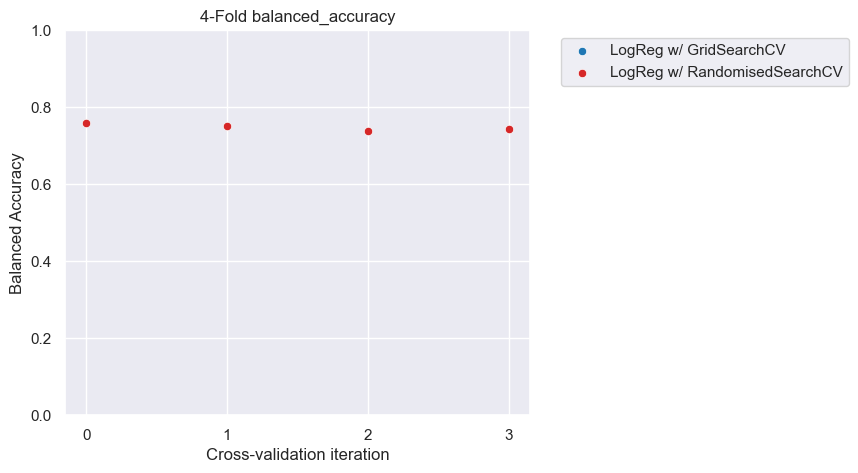

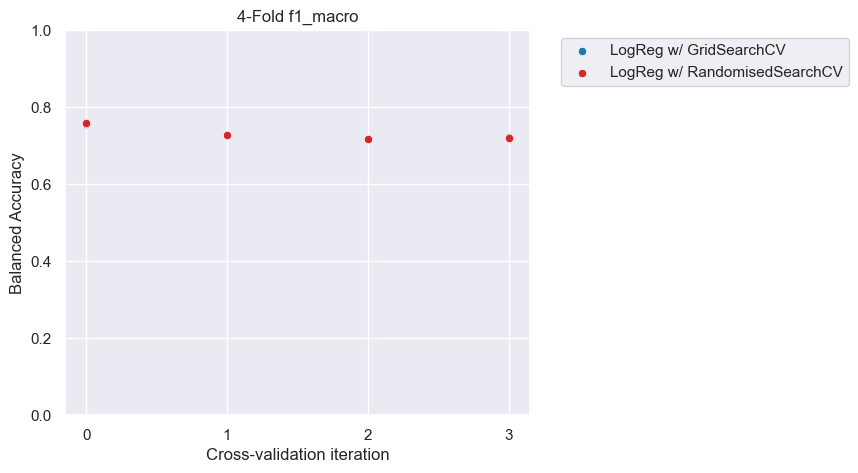

In [26]:
# plotting results from cv-folds for gridsearch and randomisedsearch logistic regression models
fold_results = (log_gridsearch_cv_score, log_randomsearch_cv_score)
label_names = ('LogReg w/ GridSearchCV', 'LogReg w/ RandomisedSearchCV')
colors=('blue', 'red')
psm.plot_fold_comparison(metric=psm.metrics[0], fold_results=fold_results, label_names=label_names, colors=colors)
psm.plot_fold_comparison(metric=psm.metrics[1], fold_results=fold_results, label_names=label_names, colors=colors)

**Which is the better linear model (tuned w/ GridSearchCV or RandomisedSearchCV)?**

* We have further proof that there is little separating the linear models tuned with GridSearchCV and RandomisedSearchCV. GridSearchCV performs slightly better in all 5-folds for the bal_accuracy metric. Whereas RandomisedSearchCV performs slightly better in 3-folds for the f1_macro metric.

* Therefore, I will be proceeding with the RandomisedSearchCV tuned model since it is ~ 2.5x quicker.

### Tree Model - Decision Tree

In [94]:
# define pipeline
tree_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("tree_classifier", DecisionTreeClassifier(random_state=42))
    ]
)

# defining evaluation metrics
scoring_bal = "balanced_accuracy"
scoring_f1 = "f1_macro"

# obtain initial estimate of variance of generalisability of model
tree_cv_results_bal = cross_validate(tree_model, data, target, cv=5, scoring=scoring_bal)
tree_scoring_cv_bal = tree_cv_results_bal['test_score']
print(
    f"The mean cross-validation {scoring_bal} score is: "
    f"{tree_scoring_cv_bal.mean():.3f} ± {tree_scoring_cv_bal.std():.3f}"
)

# obtain initial estimate of variance of generalisability of model
tree_cv_results_f1 = cross_validate(tree_model, data, target, cv=5, scoring=scoring_f1)
hist_scoring_cv_f1 = tree_cv_results_f1['test_score']
print(
    f"The mean cross-validation {scoring_f1} score is: "
    f"{hist_scoring_cv_f1.mean():.3f} ± {hist_scoring_cv_f1.std():.3f}"
)

The mean cross-validation balanced_accuracy score is: 0.643 ± 0.015
The mean cross-validation f1_macro score is: 0.643 ± 0.013


* We observe the Tree has significantly worse performance in both balanced_accuracy and in f1_macro compared to the linear model. Perhaps the data is linearly separable, or the model is significantly overfitting. We need to make it simpler.

* There are a few options we can take. Mainly, specifying a `max_depth` that controls the complexity of the tree (i.e. underfitting/overfitting). Specifying `min_samples_split`, `max_leaf_nodes`, and `min_samples_leaf` enables an asymmetric tree.

In [98]:
param_grid = {"tree_classifier__max_depth": np.arange(2, 16, 1)}

tree_max_depth_grid_search = GridSearchCV(tree_model, param_grid=param_grid, n_jobs=-1, scoring={"f1_macro": "f1_macro", "balanced_accuracy": "balanced_accuracy"}, refit="balanced_accuracy", verbose=1)
tree_max_depth_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_preprocessing',
                                                                         StandardScaler(),
                                                                         ['pts',
                                                                          'ast',
                                                                          'trb',
                                                                          'stl',
                                                                          'blk',
                                                                          'age',
                                                                          'year'])])),
                                       ('tree_classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree_classifier__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             refit='balanced_accuracy',
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro'},
             verbose=1)

In [99]:
# nested cv to evaluate best model found by gridsearch using cv - bal_accuracy
tree_cv_results_gridsearch_bal = cross_validate(tree_max_depth_grid_search, data, target, cv=5, n_jobs=2, scoring=scoring_bal)
tree_scoring_randomsearch_bal = tree_cv_results_gridsearch_bal['test_score']

# nested cv to evaluate best model found by gridsearch using cv - f1_macro
tree_cv_results_gridsearch_f1 = cross_validate(tree_max_depth_grid_search, data, target, cv=5, n_jobs=2, scoring=scoring_f1)
tree_scoring_randomsearch_f1 = tree_cv_results_gridsearch_f1['test_score']

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [100]:
# reporting results
print(
    f"{scoring_bal} with GridSearchCV hyperparameter tuning:\n"
    f"{tree_scoring_randomsearch_bal.mean():.3f} ± {tree_scoring_randomsearch_bal.std():.3f}"
)

print(
    f"{scoring_f1} with GridSearchCV hyperparameter tuning:\n"
    f"{tree_scoring_randomsearch_f1.mean():.3f} ± {tree_scoring_randomsearch_f1.std():.3f}"
)

balanced_accuracy with GridSearchCV hyperparameter tuning:
0.688 ± 0.011
f1_macro with GridSearchCV hyperparameter tuning:
0.696 ± 0.011


In [101]:
tree_max_depth_grid_search.best_params_

{'tree_classifier__max_depth': 9}

* We observe there is a significant improvement in the model after making it simpler. However, it still underperforms relative to the linear models. Can we further improve performance by adjusting other hyperparameters to allow the tree to be asynmmetric?

In [ ]:
param_grid = {"tree_classifier__max_depth": [9],
                "tree_classifier__min_samples_split": [2, 5, 10],
                "tree_classifier__min_samples_leaf": [1, 2, 4],
                "tree_classifier__max_leaf_nodes": [None, 10, 20, 50]}

tree_all_grid_search = GridSearchCV(tree_model, param_grid=param_grid, n_jobs=-1, scoring={"f1_macro": "f1_macro", "balanced_accuracy": "balanced_accuracy"}, refit="balanced_accuracy", verbose=1)
tree_all_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_preprocessing',
                                                                         StandardScaler(),
                                                                         ['pts',
                                                                          'ast',
                                                                          'trb',
                                                                          'stl',
                                                                          'blk',
                                                                          'age',
                                                                          'year'])])),
                                       ('tree_classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'tree_classifier__max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11]),
                         'tree_classifier__max_leaf_nodes': [None, 10, 20, 50],
                         'tree_classifier__min_samples_leaf': [1, 2, 4],
                         'tree_classifier__min_samples_split': [2, 5, 10]},
             refit='balanced_accuracy',
             scoring={'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro'},
             verbose=1)

In [106]:
# nested cv to evaluate best model found by gridsearch using cv - bal_accuracy
tree_cv_all_results_gridsearch_bal = cross_validate(tree_all_grid_search, data, target, cv=5, n_jobs=2, scoring=scoring_bal)
tree_all_scoring_randomsearch_bal = tree_cv_all_results_gridsearch_bal['test_score']

# nested cv to evaluate best model found by gridsearch using cv - f1_macro
tree_all_cv_results_gridsearch_f1 = cross_validate(tree_all_grid_search, data, target, cv=5, n_jobs=2, scoring=scoring_f1)
tree_all_scoring_randomsearch_f1 = tree_all_cv_results_gridsearch_f1['test_score']

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [108]:
# reporting results
print(
    f"{scoring_bal} with GridSearchCV hyperparameter tuning:\n"
    f"{tree_all_scoring_randomsearch_bal.mean():.3f} ± {tree_all_scoring_randomsearch_bal.std():.3f}"
)

print(
    f"{scoring_f1} with GridSearchCV hyperparameter tuning:\n"
    f"{tree_all_scoring_randomsearch_f1.mean():.3f} ± {tree_all_scoring_randomsearch_f1.std():.3f}"
)

balanced_accuracy with GridSearchCV hyperparameter tuning:
0.697 ± 0.008
f1_macro with GridSearchCV hyperparameter tuning:
0.706 ± 0.007


In [109]:
tree_all_grid_search.best_params_

{'tree_classifier__max_depth': 9,
 'tree_classifier__max_leaf_nodes': None,
 'tree_classifier__min_samples_leaf': 2,
 'tree_classifier__min_samples_split': 5}

### Comparison of folds between best Logistic Regression & Decision Tree models

### Histogram-based Gradient Boosting Classification Tree

In [ ]:
# define pipeline
hist_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("linear_classifier", HistGradientBoostingClassifier())
    ]
)

# defining evaluation metrics
scoring_bal = "balanced_accuracy"
scoring_f1 = "f1_macro"

# obtain initial estimate of variance of generalisability of model
cv_results = cross_validate(hist_model, data, target, cv=5, scoring=scoring_bal)
hist_scoring_cv_bal = cv_results['test_score']
print(
    f"The mean cross-validation {scoring_bal} score is: "
    f"{hist_scoring_cv_bal.mean():.3f} ± {hist_scoring_cv_bal.std():.3f}"
)

# obtain initial estimate of variance of generalisability of model
cv_results = cross_validate(hist_model, data, target, cv=5, scoring=scoring_f1)
hist_scoring_cv_f1 = cv_results['test_score']
print(
    f"The mean cross-validation {scoring_f1} score is: "
    f"{hist_scoring_cv_f1.mean():.3f} ± {hist_scoring_cv_f1.std():.3f}"
)

The mean cross-validation balanced_accuracy score is: 0.683 ± 0.038
The mean cross-validation f1_macro score is: 0.648 ± 0.090


* We observe the Gradient Boosting Classifier has significantly worse performance in both balanced_accuracy and in f1_macro compared to the linear model. Perhaps the data is linearly separable, or the model is significantly overfitting. Need to make it simpler.

### Best Model: Random Forest

In [ ]:
# Obtain predictors and response
player_predictors = player_statistics.drop(['player', 'pos'], axis = 1)
player_response = player_statistics['pos']

# Convert into 2D array with shape (n, 1)
player_response = np.array(player_response).reshape(-1, 1)

# Encode player response to be numeric
ohe = OneHotEncoder(sparse=False, categories='auto')
enc_player_response = ohe.fit_transform(player_response)

# Obtain training/test split
X_train, X_test, y_train, y_test = train_test_split(player_predictors,
                                                    enc_player_response,
                                                    train_size=0.75)

/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
rfc_pipeline = make_pipeline(StandardScaler(),
                             RandomForestClassifier(n_estimators=500, 
                                                    random_state=0))

# Define dictionary of {'param': [values_to_try]} with __ for pipeline
param_grid = {
    'randomforestclassifier__max_depth': [10, 20, 25],
    'randomforestclassifier__min_samples_leaf': [3, 4, 5, 6],
    'randomforestclassifier__bootstrap': [True, False]
}

rfc_grid = GridSearchCV(estimator=rfc_pipeline,
                    param_grid=param_grid,
                    cv = 3,
                    refit=True,
                    n_jobs = -1
                    )

rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=500,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__max_depth': [10, 20, 25],
                         'randomforestclassifier__min_samples_leaf': [3, 4, 5,
                                                                      6]})

In [ ]:
rfc_grid.best_params_

{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__min_samples_leaf': 6}

In [ ]:
# Accuracy
y_pred = rfc_grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7486055010578957


In [ ]:
# Transform back to obtain prediction
y_pred = rfc_grid.predict(X_test)
ohe.inverse_transform(y_pred[2].reshape(1, 3))

array([['F']], dtype=object)

# Retrain model on full dataset

Finally, I will retrain the model on the full dataset (training & validation sets) to help the model learn from as much data as possible.

In [ ]:
# Export model
#pickle.dump(rfc_grid, open(os.path.join("models", "stats_rf.sav"), "wb"))
#pickle.dump(ohe, open(os.path.join("models", "stats_ohe.sav"), "wb"))

# Making predictions

In [ ]:
def load_model(model):
    return pickle.load(open(model, 'rb'))
stats_predictor = load_model(os.path.join("models", "stats_rf.sav"))
stats_ohe_predictor = load_model(os.path.join("models", "stats_ohe.sav"))

# Example inputs
input_features = (np.array([[20, 10, 10, 1, 1, 31, 2000]]))
stats_predictor.predict(input_features)
predicted_pos = stats_ohe_predictor.inverse_transform(stats_predictor.predict(input_features))[0][0]   # obtain prediction using models

/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
predicted_pos

'F'

# Testing Player Similiarity Model

The model that finds the most similar active NBA player is in `similar_player_statistics.py`

### Create new dataset that contains all active player statistics

In [ ]:
player_statistics_processed.tail()

,Unnamed: 0,player,pos,pts,ast,trb,stl,blk,age,year
20791,20791,Cody Zeller,F,10.31,1.60,6.53,1.00,0.94,24.0,2017.0
20792,20792,Tyler Zeller,C,3.49,0.82,2.43,0.14,0.41,27.0,2017.0
20793,20793,Stephen Zimmerman,C,1.21,0.21,1.84,0.11,0.26,20.0,2017.0
20794,20794,Paul Zipser,F,5.45,0.82,2.84,0.34,0.36,22.0,2017.0
20795,20795,Ivica Zubac,C,7.47,0.79,4.18,0.37,0.87,19.0,2017.0


In [ ]:
active_players_processed.tail()

,playerid,fname,lname,position,height,weight,BMI
543,201152,Thaddeus,Young,F,203.20,106.594207,25.815836
544,1629027,Trae,Young,G,185.42,74.389149,21.636970
545,1630209,Omer,Yurtseven,C,210.82,124.737902,28.065631
546,203469,Cody,Zeller,F,210.82,108.862169,24.493642
547,1627826,Ivica,Zubac,C,213.36,108.862169,23.913931


In [ ]:
# Concatenate first and last names in active players
active_players_concat = active_players_processed.copy()
active_players_concat['fullname'] = active_players_processed['fname'] + ' ' + active_players_processed['lname']


In [ ]:
active_players_concat.head()

,playerid,fname,lname,position,height,weight,BMI,fullname
0,1630173,Precious,Achiuwa,F,203.20,102.058283,24.717290,Precious Achiuwa
1,203500,Steven,Adams,C,210.82,120.201978,27.045063,Steven Adams
2,1628389,Bam,Adebayo,C,205.74,115.666054,27.325521,Bam Adebayo
3,1630534,Ochai,Agbaji,G,195.58,97.522360,25.495018,Ochai Agbaji
4,1630583,Santi,Aldama,F,213.36,97.522360,21.422897,Santi Aldama


In [ ]:
# Attach on player year-by-year statistics of active players:
active_player_statistics = pd.merge(active_players_concat, player_statistics_processed, left_on = 'fullname', right_on = 'player', how = 'inner')

active_player_statistics.head()

,playerid,fname,lname,position,height,weight,BMI,fullname,Unnamed: 0,player,pos,pts,ast,trb,stl,blk,age,year
0,203500,Steven,Adams,C,210.82,120.201978,27.045063,Steven Adams,18364,Steven Adams,C,3.27,0.53,4.10,0.49,0.70,20.0,2014.0
1,203500,Steven,Adams,C,210.82,120.201978,27.045063,Steven Adams,18974,Steven Adams,C,7.67,0.94,7.47,0.54,1.23,21.0,2015.0
2,203500,Steven,Adams,C,210.82,120.201978,27.045063,Steven Adams,19625,Steven Adams,C,7.95,0.78,6.66,0.52,1.11,22.0,2016.0
3,203500,Steven,Adams,C,210.82,120.201978,27.045063,Steven Adams,20205,Steven Adams,C,11.31,1.08,7.69,1.10,0.98,23.0,2017.0
4,203937,Kyle,Anderson,F,205.74,104.326245,24.646548,Kyle Anderson,18991,Kyle Anderson,F,2.24,0.85,2.18,0.45,0.21,21.0,2015.0


In [ ]:
# Export results
active_player_statistics.to_csv(os.path.join("data", "active_player_stats.csv"))

### Test similarity model

In [ ]:
# Make a prediction with player similarity model
from similar_player_stats import SimilarPlayerStats
active_player_statistics = pd.read_csv(os.path.join("data", "active_player_stats.csv"))
similar_player_stats = SimilarPlayerStats(active_player_statistics)
print(similar_player_stats.predict_similar_player(20, 10, 5, 1, 1, 'G'))

Unnamed: 0.1               810
playerid                202322
fname                     John
lname                     Wall
position                     G
height                   190.5
weight               95.254398
BMI                  26.247931
fullname             John Wall
Unnamed: 0               18325
player               John Wall
pos                          G
pts                      18.49
ast                       7.61
trb                        4.0
stl                       1.33
blk                       0.76
age                       22.0
year                    2013.0
cosine_similarity     0.976945
Name: 810, dtype: object


/Users/danielliu/anaconda3/envs/positionn/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/danielliu/Desktop/Dev/positionn/similar_player_stats.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_pos_players['cosine_similarity'] = np.squeeze(cosine_res)


In [ ]:
# Export model
#pickle.dump(similar_player_stats, open(os.path.join("models", "similar_player_stats.pkl"), "wb"))